# 1D Asimov tests to investigate the impact of different systematic parameters on the diffuse fit uncertainty

### Header - imports, variables, useful functions and classes

In [44]:
# imports
import glob
import imp
import os

import matplotlib.pyplot as plt
import matplotlib.cbook as cbook 
import matplotlib.colors as colors 
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.interpolate import griddata as scipygrid
from scipy.interpolate import UnivariateSpline

plt.style.use(r"~/.config/matplotlib/stylelib/latex.mplstyle")
myplt = imp.load_source('myplot', '/home/pfuerst/master_thesis/software/matplotlib_tools/myplot.py')
%matplotlib inline

In [51]:
# variables
path_ace_1d = "/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist"
#systematics = sorted(os.listdir(path_ace_1d))
systematics =   ['CR_grad',
                 'barr_h',
                 'barr_w',
                 'barr_y',
                 'barr_z',
                 'delta_gamma',
                 'dom_eff',
                 'ice_abs',
                 'ice_holep0',
                 'ice_scat']

meta_scans = ['no_systematics','only_det_systematics', 'no_det_systematics', 'all_systematics',]
asimov_gamma = 2.37
asimov_phi   = 1.36

In [242]:
#/data/user/pfuerst/DiffuseExtensions/
#fitdata/no_systematics+1/ACE_fix_datahist/
#_ice_holep0_additional_scans/FitRes_0astro_norm_17653.pickle

In [282]:
# useful functions and classes

class LLHScan_1D(object):
    """class to load LLH values for a scan with just one free systematic parameter.
    """
    def __init__(self, path):

        self.path = os.path.join(path)
        self.scan_gamma_files = sorted(glob.glob(os.path.join(self.path, "*FitRes_gamma_astro*")))
        self.scan_phi_files = sorted(glob.glob(os.path.join(self.path, "*FitRes_astro_norm*")))
        self.best_fit = None
        self.min_LLH = 0.0
        self.best_gamma = None
        self.best_phi = None
        try:
            self.best_fit = pd.read_pickle(os.path.join(self.path, "Freefit.pickle"))
            self.best_gamma = self.best_fit["fit-result"][1]["gamma_astro"]
            self.best_phi = self.best_fit["fit-result"][1]["astro_norm"]
            self.min_LLH = float(self.best_fit["fit-result"][0][1])
        except:
            print("no best fit file found. Assuming best LLH = 0.0!")

    def random_file(self):
        """returns one pickle fit file."""
        return pd.read_pickle(os.path.join(path, self.scan_gamma_files[0]))
    
    def fit_results(self):
        """loops over the fit files and loads the calculated llh values at the fixed phi(gamma) position.
        """
        gammas_scan_points = []
        phis_scan_points = []
        gamma_llhs = []
        phi_llhs = []
        fitted_phis = []
        fitted_gammas = []
        
        if len(self.scan_gamma_files)>0 and len(self.scan_phi_files)>0:
            for g in self.scan_gamma_files:
                current_fit = pd.read_pickle(g)
                current_gamma = current_fit["fixed-parameters"]["gamma_astro"]
                current_llh   = 2 * (float(current_fit["fit-result"][0][1]) - self.min_LLH)
                current_fit_phi = current_fit["fit-result"][1]["astro_norm"]
                gammas_scan_points.append(current_gamma)
                gamma_llhs.append(current_llh)
                fitted_phis.append(current_fit_phi)
            for p in self.scan_phi_files:
                current_fit = pd.read_pickle(p)
                current_phi = current_fit["fixed-parameters"]["astro_norm"]
                current_llh   = 2 * (float(current_fit["fit-result"][0][1]) - self.min_LLH)
                current_fit_gamma = current_fit["fit-result"][1]["gamma_astro"]
                phis_scan_points.append(current_phi)
                phi_llhs.append(current_llh)  
                fitted_gammas.append(current_fit_gamma)
                
            gamma_llhs = np.array(gamma_llhs)
            gamma_llhs = gamma_llhs[np.argsort(np.array(gammas_scan_points))]
            fitted_phis = np.array(fitted_phis)
            fitted_phis = fitted_phis[np.argsort(np.array(gammas_scan_points))]
            gammas_scan_points = np.sort(np.array(gammas_scan_points))

            phi_llhs = np.array(phi_llhs)
            phi_llhs = phi_llhs[np.argsort(np.array(phis_scan_points))]
            fitted_gammas = np.array(fitted_gammas)
            fitted_gammas = fitted_gammas[np.argsort(np.array(phis_scan_points))]
            phis_scan_points = np.sort(np.array(phis_scan_points))

            gamma_dict = {"scan_points": np.array(gammas_scan_points),
                         "2DLLH": np.array(gamma_llhs),
                         "fitted_phis": np.array(fitted_phis)}

            phi_dict = {"scan_points": np.array(phis_scan_points),
                       "2DLLH":np.array(phi_llhs),
                       "fitted_gammas": np.array(fitted_gammas)}
            return_dict = {"gamma" : gamma_dict,
                           "phi" : phi_dict}
            return return_dict
        else:
            print("No fit files detected in {}".format(self.path))
            return None

def get_results(path, systematics):
    """builds a dictionary with keys [systematics], 
    each containing the fit results for this systematic
    """
    fit_results = {}
    for systematic in systematics:
        print("reading {} scan".format(systematic))
        scan = LLHScan_1D(os.path.join(path, systematic))
        results = scan.fit_results()
        fit_results[systematic] = results
    return fit_results
def read_random_fitfile(directory):
    """reads an arbitrary fit result pickle file from directory."""
    files = os.listdir(directory)
    return pd.read_pickle(os.path.join(directory, files[0])) 


def find_local_maximum(x,y,factor = 1.1):
    """returns index and y-values of every point in x \
    bigger than its two adjacent values.
    factor: 
        factor to multiply the comparison points by. 
    returns: 
        max_indices: indices of maxima
        max_pos: x-values of maxima
    """
    if factor < 1:
        raise ValueError("factor cannot be <1 but was set to {}".format(factor))
    if len(x) != len(y):
        raise ValueError("lists x and y must have the same lengths.")
    test_for_max = y[1:-1]
    left_vals = y[0:-2]*factor
    right_vals = y[2:]*factor
    x = np.array(x)
    mask = np.zeros(len(y))
    mask[1:-1] = np.greater(test_for_max, left_vals) & np.greater(test_for_max, right_vals)
    print(np.where(mask))
    print(x[np.where(mask)])
    max_indices= np.where(mask)
    max_pos = x[max_indices]
    return max_indices, max_pos

def fix_index(x_values, y_values, index, k=3):
    """takes x and y as 1d-arrays of same len and an index to fix. 
    returns a new y array where the specified index value is inferred by a Univariate SPline
    """
    f = UnivariateSpline(x_values, y_reduced, s=0, k=k)
    y_max = f (x_values[index])
    new_y_values = y_values
    new_y_values[index] = y_max
    return new_y_values

def delta_ratio(x_initial, y_numerator, y_denominator, y_position):
    """Function to calculate the widths of two distributions around a minimum.
    x_initial : array of x values
    y_numerator : array of y values of numerator distribution corresponding to x_initial
    y_denominator : array of y values of denominator distribution
    y_position : position on y-axis where the distribution widths are calculated
    
    returns:
    delta_num : width of numerator distr. at y_position
    delta_denom : width of denominator distr. at y_position.
    """
    yreduced_num = np.array(y_numerator) - y_position
    freduced_num = UnivariateSpline(x_initial, yreduced_num, s=0)
    delta_num = freduced_num.roots()[1]- freduced_num.roots()[0]
    
    yreduced_denom = np.array(y_denominator) - y_position
    freduced_denom = UnivariateSpline(x_initial, yreduced_denom, s=0)
    delta_denom = freduced_denom.roots()[1]- freduced_denom.roots()[0]
    return delta_num, delta_denom

def get_x_from_y(y_position, x_values, y_values, x_center = 0):
    """estimates x values for certain y value in 1-D distribution.
    returns: all x values where this distribution reaches the value y_position.
    """
    y_reduced = np.array(y_values) - y_position
    f_reduced = UnivariateSpline(x_values, y_reduced, s=0)
    deltas = []
    for root in f_reduced.roots():
        deltas.append(root-x_center)
    return deltas

def sigma_syst_base_ratio(sigma_tot, sigma_base):
    return np.sqrt((sigma_tot/sigma_base)**2 -1)

# Wilk's theorem: -2DeltaLLH distribution is approx. Chi^2-distributed (here k=2). 
# use this to estimate 1,2,3 sigma confidence intervals in LLH landscape.
sigmas = [1,2,3]
sigmas = [1,2]
levels = stats.chi2.ppf(1-2*stats.norm.sf(sigmas, 0, 1), 2) 
levelnames = []
for sigma in sigmas:
    levelnames.append(r"{} $\sigma$".format(sigma))
print(levels)

[2.29574893 6.18007431]


In [280]:
ace_results_1d = get_results(path_ace_1d,systematics)

reading CR_grad scan
reading barr_h scan
reading barr_w scan
reading barr_y scan
reading barr_z scan
reading delta_gamma scan
reading dom_eff scan
reading ice_abs scan
reading ice_holep0 scan
reading ice_scat scan


In [281]:
ace_meta_results_1d = get_results(path_ace_1d, meta_scans)

reading no_systematics scan
reading only_det_systematics scan
reading no_det_systematics scan
reading all_systematics scan


In [257]:
# calculate distribution widths at -2DeltaLLH = 1 sigma:
x_centers = {"gamma": asimov_gamma,
             "phi":   asimov_phi
            }
sorted_sigma_data_2d = {}

for dimension in ["gamma", "phi"]:
    #print(dimension)
    sigma_data = pd.DataFrame(data = systematics, columns = ["systematics"])

    systematic_parameter = systematics[0]
    sigmas_plus = []
    sigmas_minus = []
    sigmas_tot = []
    for systematic_parameter in sigma_data["systematics"]:
        #print(systematic_parameter)
        sigma_minus, sigma_plus = get_x_from_y(levels[0], 
                     ace_results_1d[systematic_parameter][dimension]["scan_points"],  
                     ace_results_1d[systematic_parameter][dimension]["2DLLH"], 
                     x_center = x_centers[dimension])
        sigmas_plus.append(sigma_plus)
        sigmas_minus.append(sigma_minus)
        sigmas_tot.append(sigma_plus - sigma_minus)
        #print(sigma_minus, sigma_plus - sigma_minus, sigma_plus)
    sigma_base_minus, sigma_base_plus = get_x_from_y(levels[0], 
                                                     ace_meta_results_1d["no_systematics"][dimension]["scan_points"],
                                                     ace_meta_results_1d["no_systematics"][dimension]["2DLLH"],
                                                    x_center = x_centers[dimension])
    sigma_base_tot = sigma_base_plus - sigma_base_minus
    #print("---")
    #print(sigma_base_minus, sigma_base_tot, sigma_base_plus)
    #print("---")
    #sigma_syst / sigma_base = sqrt(sigma_tot^2 / sigma_base^2 - 1)
    sigma_data["sigma_plus"] = sigma_syst_base_ratio(sigmas_plus,sigma_base_plus)
    sigma_data["sigma_minus"] = sigma_syst_base_ratio(sigmas_minus,  sigma_base_minus)
    sigma_data["sigma_tot"] = sigma_syst_base_ratio(sigmas_tot, sigma_base_tot)

    sorted_sigma_data = sigma_data.sort_values("sigma_tot", ascending = False)
    sorted_sigma_data_2d[dimension] = sorted_sigma_data

In [258]:
# again for metascans
sorted_sigma_data_2d_metascans = {}
for dimension in ["gamma", "phi"]:
    #print(dimension)
    sigma_data = pd.DataFrame(data = meta_scans, columns = ["meta_scans"])

    systematic_parameter = systematics[0]
    sigmas_plus = []
    sigmas_minus = []
    sigmas_tot = []
    for systematic_parameter in sigma_data["meta_scans"]:
        #print(systematic_parameter)
        sigma_minus, sigma_plus = get_x_from_y(levels[0], 
                     ace_meta_results_1d[systematic_parameter][dimension]["scan_points"],  
                     ace_meta_results_1d[systematic_parameter][dimension]["2DLLH"], 
                     x_center = x_centers[dimension])
        sigmas_plus.append(sigma_plus)
        sigmas_minus.append(sigma_minus)
        sigmas_tot.append(sigma_plus - sigma_minus)
        #print(sigma_minus, sigma_plus - sigma_minus, sigma_plus)
    sigma_base_minus, sigma_base_plus = get_x_from_y(levels[0], 
                                                     ace_meta_results_1d["no_systematics"][dimension]["scan_points"],
                                                     ace_meta_results_1d["no_systematics"][dimension]["2DLLH"],
                                                    x_center = x_centers[dimension])
    sigma_base_tot = sigma_base_plus - sigma_base_minus
    #print("---")
    #print(sigma_base_minus, sigma_base_tot, sigma_base_plus)
    #print("---")
    #sigma_syst / sigma_base = sqrt(sigma_tot^2 / sigma_base^2 - 1)
    sigma_data["sigma_plus"] = sigma_syst_base_ratio(sigmas_plus,sigma_base_plus)
    sigma_data["sigma_minus"] = sigma_syst_base_ratio(sigmas_minus,  sigma_base_minus)
    sigma_data["sigma_tot"] = sigma_syst_base_ratio(sigmas_tot, sigma_base_tot)

    sorted_sigma_data = sigma_data.sort_values("sigma_tot", ascending = False)
    sorted_sigma_data_2d_metascans[dimension] = sorted_sigma_data

In [ ]:
sorted_sigma_data_2d_metavars = {}

# Plot Fit without systematics parameters, adding them one by one. 

'to_divide = ace_meta_results_1d["no_systematics"]["gamma"]["2DLLH"]\nfor systematic_parameter in systematics:\n    if systematic_parameter != "all_systematics" and systematic_parameter != "no_systematics":\n        print(systematic_parameter)\n        ax2.plot(ace_results_1d[systematic_parameter]["gamma"]["scan_points"],\n            ace_results_1d[systematic_parameter]["gamma"]["2DLLH"]/to_divide, label=systematic_parameter)\n\nax2.axvline(asimov_gamma, color="black", linewidth = 1, linestyle=":")\nax2.set_xlabel("$\\gamma_{astro}$")\nax2.set_ylabel(\'LLH ratio\',rotation=90)\nax2.grid()'

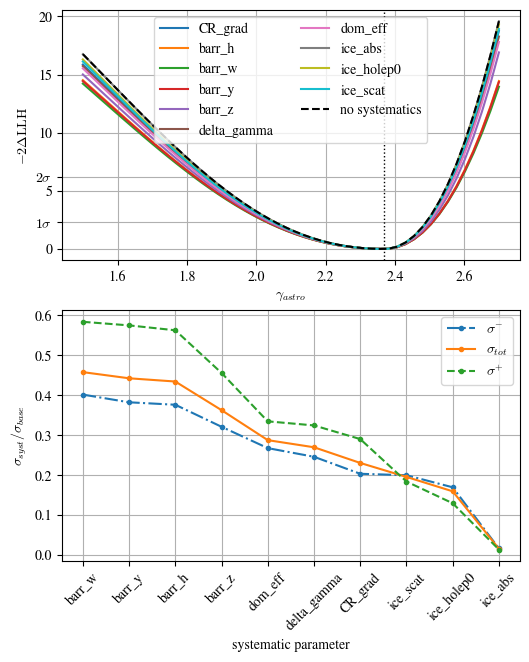

In [288]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = myplt.set_size(subplots=(2,1),ratio="golden"), dpi = 100)

# plot 1
for systematic_parameter in systematics:
    ax1.plot(ace_results_1d[systematic_parameter]["gamma"]["scan_points"],
        ace_results_1d[systematic_parameter]["gamma"]["2DLLH"], label=systematic_parameter)

ax1.plot(ace_meta_results_1d["no_systematics"]["gamma"]["scan_points"],
         ace_meta_results_1d["no_systematics"]["gamma"]["2DLLH"], 
         label = "no systematics", color="black", linestyle = "--")

#for systematic_parameter in meta_scans:
#    ax1.plot(ace_meta_results_1d[systematic_parameter]["gamma"]["scan_points"],
#        ace_meta_results_1d[systematic_parameter]["gamma"]["2DLLH"], label=systematic_parameter)
    
ax1.axvline(asimov_gamma, color="black", linewidth = 1, linestyle=":")
ax1.legend(ncol=2)
ax1.set_xlabel("$\gamma_{astro}$")
ax1.set_ylabel('$-2 \Delta\mathrm{LLH}$',rotation=90)
ax1.set_yticks([0,levels[0],5,levels[1],10,15,20])
ax1.set_yticklabels([0, "$1 \sigma$", 5, "$2 \sigma$" , 10, 15, 20])
ax1.grid()

# plot 2
sigma_labels = ["$\sigma^{-}$", "$\sigma_{tot}$", "$\sigma^{+}$"]
styles = ["-.", "-", "--"]
for idx, sigma_type in enumerate(["sigma_minus", "sigma_tot", "sigma_plus"]):
    ax2.plot(sorted_sigma_data_2d["gamma"]["systematics"], 
             sorted_sigma_data_2d["gamma"][sigma_type], 
             label = sigma_labels[idx], marker = ".", linestyle = styles[idx])
ax2.legend()
ax2.set_ylabel("$\sigma_{syst} / \sigma_{base}$")
ax2.set_xlabel("systematic parameter")
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
ax2.grid()

plt.savefig("/home/pfuerst/master_thesis/plots/NNMFit/analysis/ACE_each_syst_1d_scans_gamma.png")

"""to_divide = ace_meta_results_1d["no_systematics"]["gamma"]["2DLLH"]
for systematic_parameter in systematics:
    if systematic_parameter != "all_systematics" and systematic_parameter != "no_systematics":
        print(systematic_parameter)
        ax2.plot(ace_results_1d[systematic_parameter]["gamma"]["scan_points"],
            ace_results_1d[systematic_parameter]["gamma"]["2DLLH"]/to_divide, label=systematic_parameter)

ax2.axvline(asimov_gamma, color="black", linewidth = 1, linestyle=":")
ax2.set_xlabel("$\gamma_{astro}$")
ax2.set_ylabel('LLH ratio',rotation=90)
ax2.grid()"""

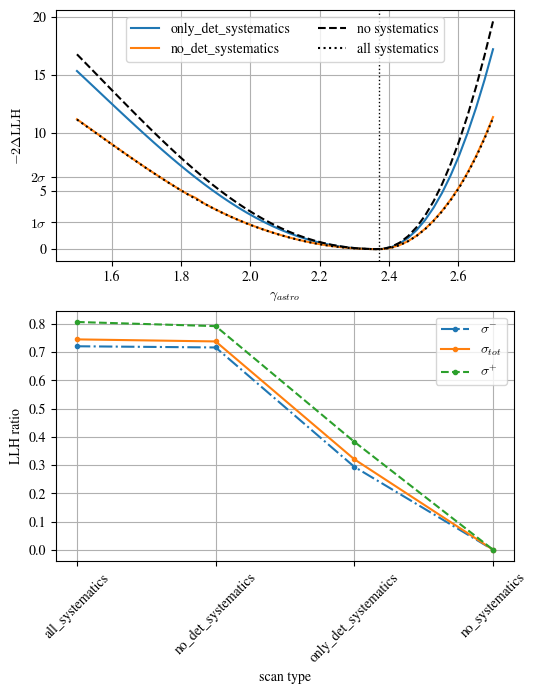

In [289]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = myplt.set_size(subplots=(2,1),ratio="golden"), dpi = 100)

# plot 1
for systematic_parameter in meta_scans:
    if systematic_parameter != "no_systematics" and systematic_parameter != "all_systematics":
        ax1.plot(ace_meta_results_1d[systematic_parameter]["gamma"]["scan_points"],
            ace_meta_results_1d[systematic_parameter]["gamma"]["2DLLH"], label=systematic_parameter)

    
ax1.plot(ace_meta_results_1d["no_systematics"]["gamma"]["scan_points"],
     ace_meta_results_1d["no_systematics"]["gamma"]["2DLLH"], 
     label = "no systematics", color="black", linestyle = "--")

ax1.plot(ace_meta_results_1d["all_systematics"]["gamma"]["scan_points"],
     ace_meta_results_1d["all_systematics"]["gamma"]["2DLLH"], 
     label = "all systematics", color="black", linestyle = ":")

#ax1.plot(ace_meta_results_1d["no_systematics"]["gamma"]["scan_points"],
#         ace_meta_results_1d["no_systematics"]["gamma"]["2DLLH"], 
#         label = "no systematics", color="black", linestyle = "--")

#ax1.plot(nodet_1d_ace["gamma"]["scan_points"],
#         nodet_1d_ace["gamma"]["2DLLH"], label = "$E_{ACE}$ no det syst", color="Green", linestyle = "--")
        
        
ax1.axvline(asimov_gamma, color="black", linewidth = 1, linestyle=":")
ax1.legend(ncol=2)
ax1.set_xlabel("$\gamma_{astro}$")
ax1.set_ylabel('$-2 \Delta\mathrm{LLH}$',rotation=90)
ax1.set_yticks([0,levels[0],5,levels[1],10,15,20])
ax1.set_yticklabels([0, "$1 \sigma$", 5, "$2 \sigma$" , 10, 15, 20])
ax1.grid()


# plot 2
sigma_labels = ["$\sigma^{-}$", "$\sigma_{tot}$", "$\sigma^{+}$"]
styles = ["-.", "-", "--"]
for idx, sigma_type in enumerate(["sigma_minus", "sigma_tot", "sigma_plus"]):
    ax2.plot(sorted_sigma_data_2d_metascans["gamma"]["meta_scans"], 
             sorted_sigma_data_2d_metascans["gamma"][sigma_type], 
             label = sigma_labels[idx], marker = ".", linestyle = styles[idx])
ax2.legend()
ax2.set_ylabel("$\sigma_{syst} / \sigma_{base}$")
ax2.set_xlabel("systematic parameter")
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
ax2.grid()


"""to_divide = ace_meta_results_1d["no_systematics"]["gamma"]["2DLLH"]
for systematic_parameter in meta_scans:
    #if systematic_parameter != "all_systematics" and systematic_parameter != "no_systematics":
    print(systematic_parameter)
    ax2.plot(ace_meta_results_1d[systematic_parameter]["gamma"]["scan_points"],
        ace_meta_results_1d[systematic_parameter]["gamma"]["2DLLH"]/to_divide, label=systematic_parameter)

#ax2.plot(trunc_full_fit["gamma"]["scan_points"],
#         trunc_full_fit["gamma"]["2DLLH"]/to_divide, label = "$E_{truncated}$ full syst", color="red")

"""

#ax2.axvline(asimov_gamma, color="black", linewidth = 1, linestyle=":")
ax2.set_xlabel("scan type")
ax2.set_ylabel('LLH ratio',rotation=90)
ax2.grid(True)

plt.savefig("/home/pfuerst/master_thesis/plots/NNMFit/analysis/ACE_meta_1d_scans_gamma.png")

In [285]:
phi_label_str = "$\Phi^{astroph.}_{@100 \mathrm{TeV}} $ $/$ $ 10^{-18} \mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1} \mathrm{sr}^{-1}$"

'to_divide = ace_meta_results_1d["no_systematics"]["phi"]["2DLLH"]\nfor systematic_parameter in systematics:\n    if systematic_parameter != "all_systematics" and systematic_parameter != "no_systematics":\n        print(systematic_parameter)\n        ax2.plot(ace_results_1d[systematic_parameter]["phi"]["scan_points"],\n            ace_results_1d[systematic_parameter]["phi"]["2DLLH"]/to_divide, label=systematic_parameter)\n\nax2.axvline(asimov_gamma, color="black", linewidth = 1, linestyle=":")\nax2.set_xlabel("$\\Phi{astro}$")\nax2.set_ylabel(\'LLH ratio\',rotation=90)\nax2.grid()'

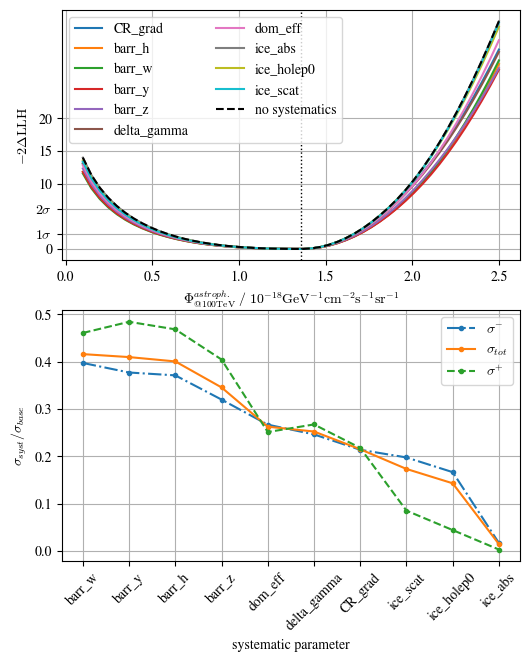

In [290]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = myplt.set_size(subplots=(2,1),ratio="golden"), dpi = 100)

# plot 1
for systematic_parameter in systematics:
    ax1.plot(ace_results_1d[systematic_parameter]["phi"]["scan_points"],
        ace_results_1d[systematic_parameter]["phi"]["2DLLH"], label=systematic_parameter)

ax1.plot(ace_meta_results_1d["no_systematics"]["phi"]["scan_points"],
         ace_meta_results_1d["no_systematics"]["phi"]["2DLLH"], 
         label = "no systematics", color="black", linestyle = "--")
      
ax1.axvline(asimov_phi, color="black", linewidth = 1, linestyle=":")
ax1.legend(ncol=2)
ax1.set_xlabel(phi_label_str)
ax1.set_ylabel('$-2 \Delta\mathrm{LLH}$',rotation=90)
ax1.set_yticks([0,levels[0],levels[1],10,15,20])
ax1.set_yticklabels([0, "$1 \sigma$", "$2 \sigma$" , 10, 15, 20])
ax1.grid()

# plot 2
sigma_labels = ["$\sigma^{-}$", "$\sigma_{tot}$", "$\sigma^{+}$"]
styles = ["-.", "-", "--"]
for idx, sigma_type in enumerate(["sigma_minus", "sigma_tot", "sigma_plus"]):
    ax2.plot(sorted_sigma_data_2d["phi"]["systematics"], 
             sorted_sigma_data_2d["phi"][sigma_type], 
             label = sigma_labels[idx], marker = ".", linestyle = styles[idx])
ax2.legend()
ax2.set_ylabel("$\sigma_{syst} / \sigma_{base}$")
ax2.set_xlabel("systematic parameter")
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
ax2.grid()


plt.savefig("/home/pfuerst/master_thesis/plots/NNMFit/analysis/ACE_each_syst_1d_scans_phi.png")

"""to_divide = ace_meta_results_1d["no_systematics"]["phi"]["2DLLH"]
for systematic_parameter in systematics:
    if systematic_parameter != "all_systematics" and systematic_parameter != "no_systematics":
        print(systematic_parameter)
        ax2.plot(ace_results_1d[systematic_parameter]["phi"]["scan_points"],
            ace_results_1d[systematic_parameter]["phi"]["2DLLH"]/to_divide, label=systematic_parameter)

ax2.axvline(asimov_gamma, color="black", linewidth = 1, linestyle=":")
ax2.set_xlabel("$\Phi{astro}$")
ax2.set_ylabel('LLH ratio',rotation=90)
ax2.grid()"""


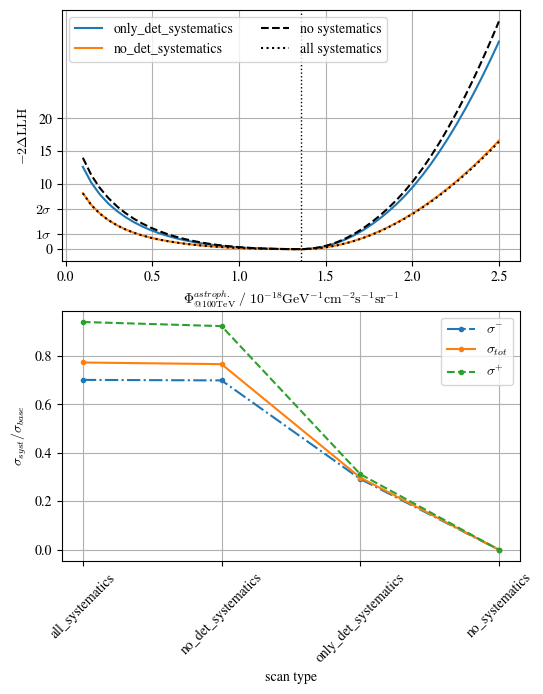

In [292]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = myplt.set_size(subplots=(2,1),ratio="golden"), dpi = 100)

# plot 1
for systematic_parameter in meta_scans:
    if systematic_parameter != "no_systematics" and systematic_parameter !="all_systematics":
        ax1.plot(ace_meta_results_1d[systematic_parameter]["phi"]["scan_points"],
            ace_meta_results_1d[systematic_parameter]["phi"]["2DLLH"], label=systematic_parameter)

ax1.plot(ace_meta_results_1d["no_systematics"]["phi"]["scan_points"],
         ace_meta_results_1d["no_systematics"]["phi"]["2DLLH"], 
         label = "no systematics", color="black", linestyle = "--")

ax1.plot(ace_meta_results_1d["all_systematics"]["phi"]["scan_points"],
         ace_meta_results_1d["all_systematics"]["phi"]["2DLLH"], 
         label = "all systematics", color="black", linestyle = ":")

ax1.axvline(asimov_phi, color="black", linewidth = 1, linestyle=":")
ax1.legend(ncol=2)
ax1.set_xlabel(phi_label_str)
ax1.set_ylabel('$-2 \Delta\mathrm{LLH}$',rotation=90)
ax1.set_yticks([0,levels[0],levels[1],10,15,20])
ax1.set_yticklabels([0, "$1 \sigma$", "$2 \sigma$" , 10, 15, 20])
ax1.grid()

# plot 2
sigma_labels = ["$\sigma^{-}$", "$\sigma_{tot}$", "$\sigma^{+}$"]
styles = ["-.", "-", "--"]
for idx, sigma_type in enumerate(["sigma_minus", "sigma_tot", "sigma_plus"]):
    ax2.plot(sorted_sigma_data_2d_metascans["phi"]["meta_scans"], 
             sorted_sigma_data_2d_metascans["phi"][sigma_type], 
             label = sigma_labels[idx], marker = ".", linestyle = styles[idx])
ax2.legend()
ax2.set_ylabel("$\sigma_{syst} / \sigma_{base}$")
ax2.set_xlabel("scan type")
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
ax2.grid()

plt.savefig("/home/pfuerst/master_thesis/plots/NNMFit/analysis/ACE_meta_1d_scans_phi.png")


In [256]:
# do additional scans where the minimizer fails. 
# success quote is about 20% so in 10 scans there usually is one finding the actual minimum. 

In [230]:
systematic_parameter = "ice_holep0"
y = ace_results_1d[systematic_parameter]["phi"]["2DLLH"] / ace_meta_results_1d["no_systematics"]["phi"]["2DLLH"]
x = ace_results_1d[systematic_parameter]["phi"]["scan_points"]

In [231]:
find_local_maximum(x,y)

(array([34]),)
[1.76530612]


((array([34]),), array([1.76530612]))

In [240]:
ace_results_1d[systematic_parameter]["phi"]["2DLLH"][34]/2.

2.9222700828686357

In [276]:
systematic_parameter = "CR_grad"
y = ace_results_1d[systematic_parameter]["gamma"]["2DLLH"] / ace_meta_results_1d["no_systematics"]["gamma"]["2DLLH"]
x = ace_results_1d[systematic_parameter]["gamma"]["scan_points"]

In [277]:
find_local_maximum(x,y)

(array([44]),)
[2.57755102]


((array([44]),), array([2.57755102]))

In [279]:
ace_results_1d[systematic_parameter]["gamma"]["2DLLH"][44]/2

4.343178942333907

In [241]:
additional_hole_ice_scans_path = "/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_ice_holep0_additional_scans"
fitfiles = sorted(glob.glob(os.path.join(additional_hole_ice_scans_path, "*FitRes_*astro_norm*")))
for file in fitfiles:
    a = pd.read_pickle(os.path.join(additional_hole_ice_scans_path, file))
    print(file)
    print(a["fit-result"][0][1])


/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_ice_holep0_additional_scans/FitRes_0astro_norm_17653.pickle
2.048357273917645
/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_ice_holep0_additional_scans/FitRes_1astro_norm_17653.pickle
2.048357273917645
/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_ice_holep0_additional_scans/FitRes_2astro_norm_17653.pickle
2.9222789690829813
/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_ice_holep0_additional_scans/FitRes_3astro_norm_17653.pickle
2.9222789690829813
/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_ice_holep0_additional_scans/FitRes_4astro_norm_17653.pickle
2.9222789690829813
/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_ice_holep0_additional_scans/FitRes_5astro_norm_17653.pickle
2.9222790021449327
/data/user/pfuerst/DiffuseExtensions/fitdata/no_

In [232]:
#perform a fit with fix phi = 1.76530612, ice_holep0 is free and all others are fixed. do this fit x10 times.

In [274]:
additional_CR_grad_scans_path = "/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_CR_grad_additional_scans"
fitfiles = sorted(glob.glob(os.path.join(additional_CR_grad_scans_path, "*FitRes_*gamma_astro*")))
for file in fitfiles:
    a = pd.read_pickle(os.path.join(additional_hole_ice_scans_path, file))
    print(file)
    print(a["fit-result"][0][1])

/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_CR_grad_additional_scans/FitRes_0gamma_astro_25775.pickle
3.4186464715749025
/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_CR_grad_additional_scans/FitRes_11gamma_astro_25775.pickle
3.4186464711092412
/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_CR_grad_additional_scans/FitRes_12gamma_astro_25775.pickle
3.4186464715749025
/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_CR_grad_additional_scans/FitRes_13gamma_astro_25775.pickle
3.4186464715749025
/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_CR_grad_additional_scans/FitRes_14gamma_astro_25775.pickle
3.4186464715749025
/data/user/pfuerst/DiffuseExtensions/fitdata/no_systematics+1/ACE_fix_datahist/_CR_grad_additional_scans/FitRes_16gamma_astro_25775.pickle
3.4186464711092412
/data/user/pfuerst/DiffuseExtensions/fitdata/no_syste

### Investigate impact of sigma level on error ratios

In [293]:
print(levels)

[2.29574893 6.18007431]


In [297]:
many_levels = np.linspace(1,7, 100)

gamma_left  = []
gamma_right = []
gamma_tot = []
for level in many_levels:
    widths_all_syst_neg, widths_all_syst_pos = get_x_from_y(level, ace_meta_results_1d["all_systematics"]["phi"]["scan_points"],ace_meta_results_1d["all_systematics"]["phi"]["2DLLH"], x_center = asimov_phi)
    widths_no_syst_neg,  widths_no_syst_pos  = get_x_from_y(level, ace_meta_results_1d["no_systematics"]["phi"]["scan_points"], ace_meta_results_1d["no_systematics"]["phi"]["2DLLH"],  x_center = asimov_phi)
    widths_all_syst_tot = widths_all_syst_pos -  widths_all_syst_neg
    widths_no_syst_tot = widths_no_syst_pos - widths_no_syst_neg
    
    sigma_ratio_pos = sigma_syst_base_ratio(widths_all_syst_pos, widths_no_syst_pos)
    sigma_ratio_neg = sigma_syst_base_ratio(widths_all_syst_neg, widths_no_syst_neg)
    sigma_ratio_tot = sigma_syst_base_ratio(widths_all_syst_tot,  widths_no_syst_tot)
    gamma_left.append(sigma_ratio_neg)
    gamma_right.append(sigma_ratio_pos)
    gamma_tot.append(sigma_ratio_tot)
    
    #num_g, denom_g = delta_ratio(ace_meta_results_1d["all_systematics"]["gamma"]["scan_points"], 
    #                         ace_meta_results_1d["all_systematics"]["gamma"]["2DLLH"],
    #                         ace_meta_results_1d["no_systematics"]["gamma"]["2DLLH"],
    #                         y_position = level)
    #ratio_gamma = sigma_syst_stat_ratio(num_g, denom_g)
    #gamma_tot.append(ratio_gamma)

In [298]:
phi_left  = []
phi_right = []
phi_tot = []
for level in many_levels:
    widths_all_syst_neg, widths_all_syst_pos = get_x_from_y(level, ace_meta_results_1d["all_systematics"]["phi"]["scan_points"],ace_meta_results_1d["all_systematics"]["phi"]["2DLLH"], x_center = asimov_phi)
    widths_no_syst_neg,  widths_no_syst_pos  = get_x_from_y(level, ace_meta_results_1d["no_systematics"]["phi"]["scan_points"], ace_meta_results_1d["no_systematics"]["phi"]["2DLLH"],  x_center = asimov_phi)
    widths_all_syst_tot = widths_all_syst_pos -  widths_all_syst_neg
    widths_no_syst_tot = widths_no_syst_pos - widths_no_syst_neg
    
    sigma_ratio_pos = sigma_syst_stat_ratio(widths_all_syst_pos, widths_no_syst_pos)
    sigma_ratio_neg = sigma_syst_stat_ratio(widths_all_syst_neg, widths_no_syst_neg)
    sigma_ratio_tot = sigma_syst_base_ratio(widths_all_syst_tot,  widths_no_syst_tot)

    phi_left.append(sigma_ratio_neg)
    phi_right.append(sigma_ratio_pos)
    phi_tot.append(sigma_ratio_tot)


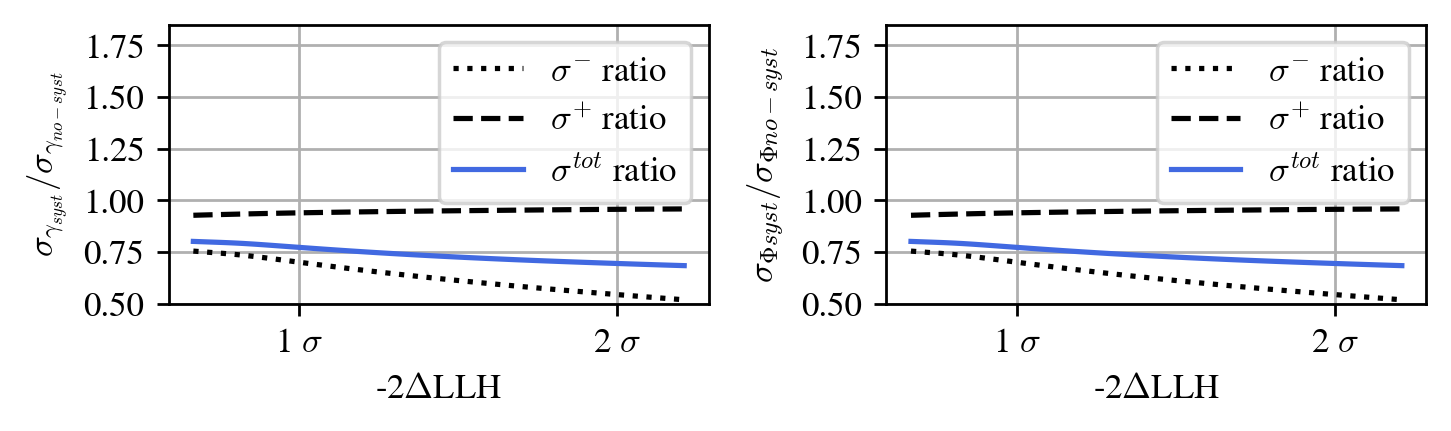

In [302]:
mysize = myplt.set_size(subplots = (1,2), ratio = "golden", squeeze_height = 1)

fig, (ax1,ax2) = plt.subplots(1,2,figsize = mysize, dpi = 250)

tot_col = "royalblue"
plus_col = "black"
minus_col = "black"
# ax1
ax1.plot(many_levels, gamma_left,  label = "$\sigma^{-}$ ratio",  color = minus_col, linestyle = ":")
ax1.plot(many_levels, gamma_right, label = "$\sigma^{+}$ ratio",  color = plus_col, linestyle = "--")
ax1.plot(many_levels, gamma_tot,   label = "$\sigma^{tot}$ ratio",color = tot_col)

legend = ax1.legend(loc="upper right")#framealpha = 1
frame = legend.get_frame()
#frame.set_facecolor('white')
ax1.grid(True)
ax1.set_xticks(levels)
ax1.set_xticklabels(levelnames)
ax1.set_xlabel("-2$\Delta$LLH")
ax1.set_yticks([0.5,0.75,1.0,1.25,1.5, 1.75])
#ax1.yaxis.set_tick_params(which='both')
ax1.set_ylim(0.5,1.85)
ax1.set_ylabel("$\sigma_{\gamma_{syst}} / \sigma_{\gamma_{no-syst}}$")
# ax2
ax2.plot(many_levels, phi_left,  label = "$\sigma^{-}$ ratio",   color = minus_col, linestyle = ":")
ax2.plot(many_levels, phi_right, label = "$\sigma^{+}$ ratio",   color = plus_col, linestyle = "--")
ax2.plot(many_levels, phi_tot,   label = "$\sigma^{tot}$ ratio", color = tot_col)

legend = ax2.legend(loc="upper right")
frame = legend.get_frame()
#frame.set_facecolor('white')
ax2.grid(True)
ax2.set_ylabel("$\sigma_{\Phi{syst}} / \sigma_{\Phi{no-syst}}$")
ax2.set_xlabel("-2$\Delta$LLH")
ax2.set_yticks([0.5,0.75,1.0,1.25,1.5, 1.75])
ax2.set_ylim(0.5,1.85)
ax2.set_xticks(levels)
ax2.set_xticklabels(levelnames)
plt.tight_layout()

plt.savefig("/home/pfuerst/master_thesis/plots/NNMFit/analysis/stat_plus1_syst_stat_ratios_wDET_SYST.png")

In [300]:
print(np.mean(np.hstack((gamma_left, gamma_right, gamma_tot))))
print(np.mean(np.hstack((phi_left, phi_right, phi_tot))))

print(np.std(np.hstack((gamma_left, gamma_right, gamma_tot))))
print(np.std(np.hstack((phi_left, phi_right, phi_tot))))

0.7711399525658397
0.7711399525658397
0.14012924968344548
0.14012924968344548
